### Uncomment and run the below code block if you do not already have the below libraries installed.

In [ ]:
# !pip install sklearn
# !pip install pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.0.2


In [ ]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NQU_data_modi.csv')
# check that the data is imported properly
df.head()

,SM,MM,shader,core,l1,latency,dl2,IPC
0,34,2,8,24,64,35,128,29.5952
1,46,3,32,12,32,20,64,29.5098
2,47,2,16,12,64,82,128,28.8188
3,31,5,8,48,32,20,128,30.0998
4,42,7,16,24,32,35,64,29.7569


### Exploratory Data Analysis:

In [ ]:
df.mean()

SM         51.947822
MM          4.057576
shader     30.001285
core       27.989719
l1         48.002056
latency    45.661997
dl2        95.987662
IPC        28.990125
dtype: float64

In [ ]:
df.median()

SM         56.0000
MM          4.0000
shader     32.0000
core       24.0000
l1         64.0000
latency    35.0000
dl2        64.0000
IPC        29.1384
dtype: float64

In [ ]:
df.tail()

,SM,MM,shader,core,l1,latency,dl2,IPC
7776,22,3,64,12,32,35,64,30.3137
7777,20,5,8,48,64,82,64,30.2779
7778,24,1,16,12,32,82,64,29.7876
7779,22,3,32,24,32,20,128,30.3116
7780,20,5,32,12,32,35,64,30.3827


In [ ]:
df.describe()

,SM,MM,shader,core,l1,latency,dl2,IPC
count,7781.000000,7781.000000,7781.000000,7781.000000,7781.000000,7781.000000,7781.000000,7781.000000
mean,51.947822,4.057576,30.001285,27.989719,48.002056,45.661997,95.987662,28.990125
std,29.811224,2.438820,21.442156,14.968275,16.001028,26.411459,32.002054,1.254127
min,2.000000,1.000000,8.000000,12.000000,32.000000,20.000000,64.000000,24.955100
25%,24.000000,2.000000,16.000000,12.000000,32.000000,20.000000,64.000000,28.369500
50%,56.000000,4.000000,32.000000,24.000000,64.000000,35.000000,64.000000,29.138400
75%,77.000000,6.000000,32.000000,48.000000,64.000000,82.000000,128.000000,30.030700
max,99.000000,10.000000,64.000000,48.000000,64.000000,82.000000,128.000000,30.548400


In [ ]:
df.shape

(7781, 8)

###Functions

In [ ]:
import warnings
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statistics
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

In [ ]:
#machine learning functions
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit, LeavePOut
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import math
from sklearn.svm import SVC, SVR
from matplotlib import rcParams
#write functions

import warnings
warnings.filterwarnings('ignore')
# to filter out warnings at this time

def outer_cross_val(X, Y, validation_method, model, params ,\
                    model_type = 'Regression', min_samples = 10):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")
    
    labels_matrix = np.unique(Y)
    #print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification':
        best_score = 0 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    total_r2 = 0
    for train_index, test_index in validation_method.split(X, Y):
        #for each group split, do a nested cross validation
        # print('train_index: ', train_index)
        # print('test_index: ', test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # nested_groups = groups[train_index]
        
        #optmized model from training set (validation done in nested function)
        best_nested_model = nested_cross_val(X_train, Y_train, \
                                            validation_method, model, params)
        #print the parameters for the model in the nested 
        
        print('best_nested_model: ', best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)
        
        Y_pred = best_nested_model.predict(X_test)
        
        # Y_pred_q = np.round_(Y_pred, decimals = 0)
        
        #nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        #print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
        
        nested_score = rsme(Y_test, Y_pred)
        print('nested_score: ', nested_score)
        nested_r2 = metrics.r2_score(Y_test,Y_pred)
        print('nested_r2: ', nested_r2)
        # nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        # nested_f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
        #compile all results for the confusion matrix
        # consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
        #                                     labels=labels_matrix)
        print('Y_test: ', Y_test)
       # print(min_samples)
        print('best_score: ', best_score)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_R2 = nested_r2
                best_x_train = X_train
                best_y_train = Y_train
                best_x_test = X_test
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_score
            total_r2 += nested_r2
        elif model_type == 'Classification':
            #if classification, compare accuracy
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy
            
                
        count += 1
        
    average_score = total_score/count
    average_r2 = total_r2/count
    
    if model_type == 'Reg_R2' or 'Regression':
        rcParams['figure.figsize'] = 5,5
        fig, ax = plt.subplots()
        ax.scatter(best_y_test,best_y_pred, alpha=.5,c = 'black')
        
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

#         # now plot both limits against eachother
#         ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        #obtain m (slope) and b(intercept) of linear regression line
#         m, b = np.polyfit(best_y_test, best_y_pred, 1)

#         #add linear regression line to scatterplot 
#         ax.plot(best_y_test, m*best_y_test+b)

        sns.regplot(best_y_test, best_y_pred,color='black',ci=95, scatter_kws={'alpha':0.01})
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel('Actual Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title('NQU')
#         fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_reg.svg' % subscore)
        plt.show()

        rcParams['figure.figsize'] = 6,4
        visualizer = ResidualsPlot(best_model_overall,hist = True)
        visualizer.fit(best_x_train, best_y_train)  # Fit the training data to the visualizer
        visualizer.score(best_x_test, best_y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure
        
        # visualizer = ResidualsPlot(best_model_overall,hist = False,qqplot=True)
        # visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
        # visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
        # visualizer.show()                 # Finalize and render the figure

    final_scoring = best_score, average_score, best_y_test, best_y_pred, best_R2, average_r2
  
    return best_model_overall, final_scoring


def nested_cross_val(X, Y, validation_method, model, params):
    #print("Inner Cross Validation")
    #X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv = validation_method.split(X, Y)).fit(X, Y)
    #print(test_model.best_estimator_)
    #print(test_model.scorer_)
    return test_model.best_estimator_
    
def rsme(predictions, target):
    #root squared mean error
    return np.sqrt(((predictions - target) **2).mean())

#calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

#use the binom class from scipi
from scipy.stats import binom

def binomial_range(x, N, confidence_level = 0.95):
    #print("Calculate Binomal")
    #c_high = 1 - (confidence_level/2)
    #c_low = 1 - (confidence_level/2)
    prob = (x*1.0)/N
    #use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0]/N, nums[1]/N
    #exact_confidence_interval(x, N, c_high, c_low)
    
def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

###SVR

In [ ]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 6, 7)
# print(Y)
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done 

In [ ]:
print([pow(10,i) for i in range(8,-5, -1)])

[100000000, 10000000, 1000000, 100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]


Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.33207602154481924
nested_r2:  0.9278373644830763
Y_test:  [29.7569 29.0674 29.6345 ... 30.0772 30.3137 29.7876]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.32949366423040866
nested_r2:  0.9267854967995313
Y_test:  [29.5098 29.9442 29.6345 ... 30.0347 30.3813 30.0433]
best_score:  0.33207602154481924
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3308625606089802
nested_r2:  0.9346058281401178
Y_test:  [29.5952 30.0998 29.956  ... 30.0798 30.3116 30.3827]
best_score:  0.32949366423040866
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.34728469328684825
nested_r2:  0.9256628708246238
Y_test:  [29.6571 29.6707 29.5098 ... 30.2779 29.9924 30.2779]
best_score:  0.32949366423040866
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.32585328498535127
nested_r2:  0.9315936559308294
Y_test:  [28.8188 29.991  29.6345

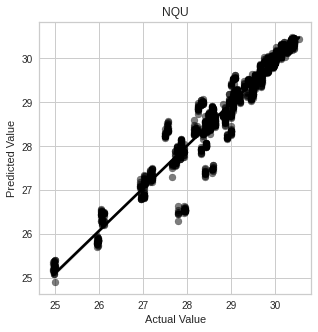

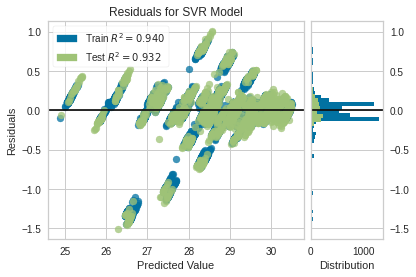

best score: 0.325853
best R2_score: 0.931594
average score: 0.333114 
average R2: 0.929297 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3250776088665367
nested_r2:  0.9349576471471546
Y_test:  [29.5098 30.0998 29.6707 ... 30.3813 30.3137 30.3827]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3372549356012676
nested_r2:  0.9242285226936562
Y_test:  [29.6345 29.6345 29.0674 ... 30.3813 30.2779 29.7876]
best_score:  0.3250776088665367
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.35463192328020415
nested_r2:  0.9227308171685322
Y_test:  [29.9442 29.556  29.8333 ... 30.3813 30.2094 29.9924]
best_score:  0.3250776088665367
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3468229006177835
nested_r2:  0.9222047811247078
Y_test:  [29.5952 28.8188 29.991  ... 30.0772 30.0798 30.2779]
best_score:  0.3250776088665367
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.31361191169119557
nested_r2:  0.9368621072923269
Y_test:  [29.7569 29.4862 29.5098 ... 

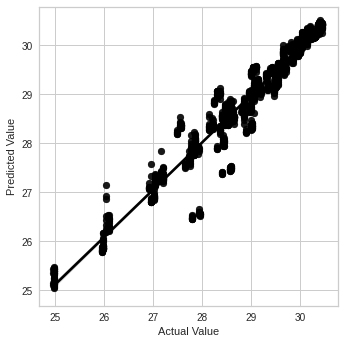

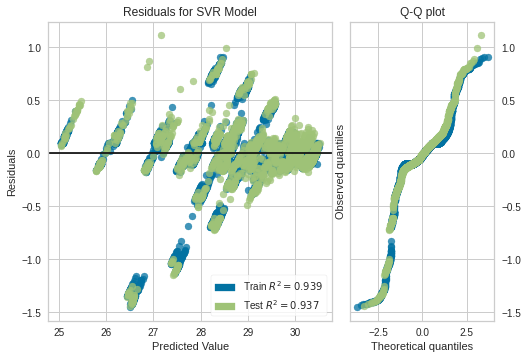

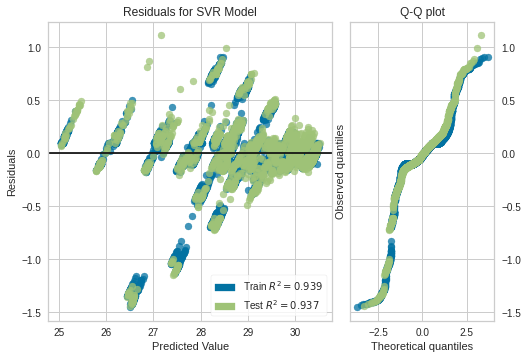

best score: 0.313612
best R2_score: 0.936862
average score: 0.335480 
average R2: 0.928197 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.32840589282768695
nested_r2:  0.9326617925557658
Y_test:  [29.556  29.991  29.8333 ... 30.2779 29.9924 30.2779]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3407414708950301
nested_r2:  0.9315423494863724
Y_test:  [29.5952 28.8188 29.991  ... 30.0772 30.3813 29.7876]
best_score:  0.32840589282768695
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.33590744938290557
nested_r2:  0.9248361855414475
Y_test:  [29.6707 29.4804 29.991  ... 30.1458 29.9192 30.0798]
best_score:  0.32840589282768695
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3384543182450863
nested_r2:  0.9239461405689356
Y_test:  [29.5098 30.0998 29.7569 ... 30.3137 30.3116 30.3827]
best_score:  0.32840589282768695
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  0.3327545098454854
nested_r2:  0.9288535666390532
Y_test:  [29.6345 29.9442 29.3002 .

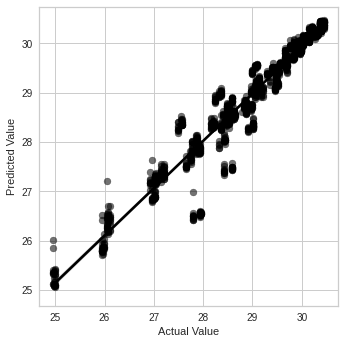

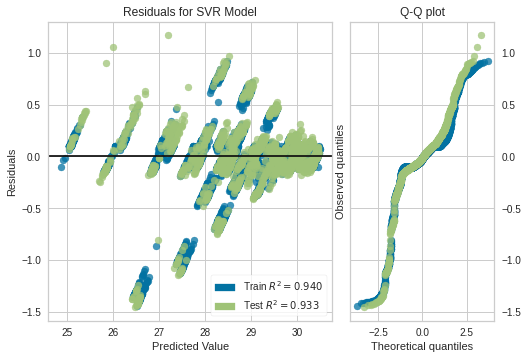

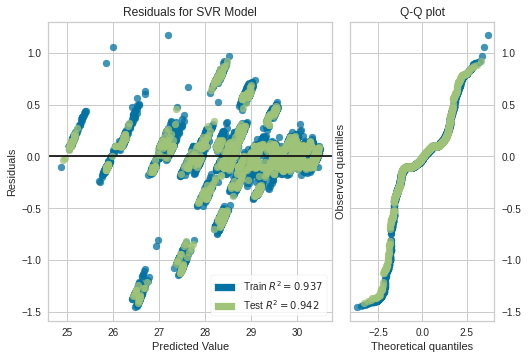

best score: 0.328406
best R2_score: 0.932662
average score: 0.335253 
average R2: 0.928368 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)